In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalMaxPool1D
from keras import optimizers
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.constraints import maxnorm

from deception_detection import concat_datasets, simplify_labels, split_dataframe, stemming_documents, encode_categorical_data, preprocess_data, k_fold_cross_validation, tokenize_dataset, create_embedding_matrix, plot_history


Using TensorFlow backend.


In [2]:
def execute_ann_tf_idf(mode='cv'):
    df = concat_datasets(pd.read_csv('datasets/train.tsv', sep='\t'),
                pd.read_csv('datasets/test.tsv', sep='\t'),
                pd.read_csv('datasets/valid.tsv', sep='\t'))
    X, y = split_dataframe(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)
    tf_idf = TfidfVectorizer(max_df=0.5)

    X_train, y_train = preprocess_data(X_train, y_train, 'train', tf_idf)
    X_test, y_test = preprocess_data(X_test, y_test, 'test', tf_idf)
    
    def build_ann_classifier():
        classifier = Sequential()
        classifier.add(Dense(units=64, kernel_initializer='uniform', activation='relu', input_shape=(10640,), kernel_constraint=maxnorm(1)))
        classifier.add(Dropout(0.4))
        classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

        rmsprop = optimizers.RMSprop(0.001)
        classifier.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

        return classifier
    
    if mode == 'cv':
        accuracy, variance = k_fold_cross_validation(X_train, y_train, build_ann_classifier, 5, 32, 3)
        print('Accuracy: {}\nVariance: {}\n'.format(accuracy, variance))
    else:
        acc = []
        val_acc = []
        loss = []
        val_loss = []
        test_acc = []
        
        for i in range(30):
            classifier = build_ann_classifier()

            history = classifier.fit(X_train, y_train,
                                epochs=3,
                                validation_split=0.2,
                                batch_size=32,
                                verbose=0)
            
            acc_v = history.history['acc']
            val_acc_v = history.history['val_acc']
            loss_v = history.history['loss']
            val_loss_v = history.history['val_loss']
            
            plot_history(acc_v, val_acc_v, loss_v, val_loss_v, 'acc_loss_ann_tuned_{}'.format(i))

            acc.append(acc_v)
            val_acc.append(val_acc_v)
            loss.append(loss_v)
            val_loss.append(val_loss_v)

            test_acc.append(classifier.evaluate(X_test, y_test)[1])

        acc = np.array(acc).mean(axis=0)
        val_acc = np.array(val_acc).mean(axis=0)
        loss = np.array(loss).mean(axis=0)
        val_loss = np.array(val_loss).mean(axis=0)
        
        plot_history(acc, val_acc, loss, val_loss, 'acc_loss_ann_average_tuned')

        print('ANN')
        print(test_acc)


def execute_ann_tokenized(mode='cv'):
    df = concat_datasets(pd.read_csv('datasets/train.tsv', sep='\t'),
                pd.read_csv('datasets/test.tsv', sep='\t'),
                pd.read_csv('datasets/valid.tsv', sep='\t'))

    X, y = split_dataframe(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train, y_train = tokenize_dataset(tokenizer, X_train, y_train)
    X_test, y_test = tokenize_dataset(tokenizer, X_test, y_test)
    max_len = 100
    
    X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
    X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

    def build_ann_classifier_tokenized():
        classifier = Sequential()
        classifier.add(Dense(4, kernel_initializer='uniform', activation='relu', input_dim=100, kernel_constraint=maxnorm(3)))
        classifier.add(Dropout(0.1))
        classifier.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

        rmsprop = optimizers.RMSprop(0.001)
        classifier.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

        return classifier

    if mode == 'cv':
        accuracy, variance = k_fold_cross_validation(X_train, y_train, build_ann_classifier_tokenized, 5, 64, 15)
        print('Accuracy: {}\nVariance: {}\n'.format(accuracy, variance))
    else:
        acc = []
        val_acc = []
        loss = []
        val_loss = []
        test_acc = []
        
        for i in range(30):
            classifier = build_ann_classifier_tokenized()

            history = classifier.fit(X_train, y_train,
                                epochs=15,
                                validation_split=0.2,
                                batch_size=64,
                                verbose=0)
            
            acc_v = history.history['acc']
            val_acc_v = history.history['val_acc']
            loss_v = history.history['loss']
            val_loss_v = history.history['val_loss']
            
            plot_history(acc_v, val_acc_v, loss_v, val_loss_v, 'acc_loss_ann_tokenized__tuned_{}'.format(i))

            acc.append(acc_v)
            val_acc.append(val_acc_v)
            loss.append(loss_v)
            val_loss.append(val_loss_v)

            test_acc.append(classifier.evaluate(X_test, y_test)[1])

        acc = np.array(acc).mean(axis=0)
        val_acc = np.array(val_acc).mean(axis=0)
        loss = np.array(loss).mean(axis=0)
        val_loss = np.array(val_loss).mean(axis=0)
        
        plot_history(acc, val_acc, loss, val_loss, 'acc_loss_ann_tokenized_average_tuned')

        print('ANN tokenized')
        print(test_acc)


def execute_cnn(mode='cv'):
    df = concat_datasets(pd.read_csv('datasets/train.tsv', sep='\t'),
                pd.read_csv('datasets/test.tsv', sep='\t'),
                pd.read_csv('datasets/valid.tsv', sep='\t'))

    X, y = split_dataframe(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train, y_train = tokenize_dataset(tokenizer, X_train, y_train)
    X_test, y_test = tokenize_dataset(tokenizer, X_test, y_test)

    vocab_size = len(tokenizer.word_index) + 1
    max_len = 100
    
    X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
    X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

    embedding_matrix = create_embedding_matrix('datasets/glove.6B.50d.txt', tokenizer.word_index, 50)

    def build_cnn_classifier():
        classifier = Sequential()
        classifier.add(Embedding(input_dim=12500, output_dim=50, weights=[embedding_matrix], input_length=100, trainable=True))
        classifier.add(Dropout(0.3))
        classifier.add(Conv1D(64, 2, kernel_initializer='uniform', activation='relu'))
        classifier.add(GlobalMaxPool1D())
        classifier.add(Dense(10, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
        classifier.add(Dropout(0.4))
        classifier.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
        
        rmsprop = optimizers.RMSprop(0.001)
        classifier.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

        return classifier
    
    if mode == 'cv':
        accuracy, variance = k_fold_cross_validation(X_train, y_train, build_cnn_classifier, 5, 128, 10)
        print('Accuracy: {}\nVariance: {}\n'.format(accuracy, variance))
    else:
        acc = []
        val_acc = []
        loss = []
        val_loss = []
        test_acc = []
        
        for i in range(30):
            classifier = build_cnn_classifier()

            history = classifier.fit(X_train, y_train,
                                epochs=10,
                                validation_split=0.2,
                                batch_size=128,
                                verbose=0)
            
            acc_v = history.history['acc']
            val_acc_v = history.history['val_acc']
            loss_v = history.history['loss']
            val_loss_v = history.history['val_loss']
            
            plot_history(acc_v, val_acc_v, loss_v, val_loss_v, 'acc_loss_cnn_tuned_{}'.format(i))

            acc.append(acc_v)
            val_acc.append(val_acc_v)
            loss.append(loss_v)
            val_loss.append(val_loss_v)

            test_acc.append(classifier.evaluate(X_test, y_test)[1])

        acc = np.array(acc).mean(axis=0)
        val_acc = np.array(val_acc).mean(axis=0)
        loss = np.array(loss).mean(axis=0)
        val_loss = np.array(val_loss).mean(axis=0)
        
        plot_history(acc, val_acc, loss, val_loss, 'acc_loss_cnn_average_tuned')

        print('CNN')
        print(test_acc)

In [24]:
df = concat_datasets(pd.read_csv('datasets/train.tsv', sep='\t'),
            pd.read_csv('datasets/test.tsv', sep='\t'),
            pd.read_csv('datasets/valid.tsv', sep='\t'))

X, y = split_dataframe(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train, y_train = tokenize_dataset(tokenizer, X_train, y_train)
X_test, y_test = tokenize_dataset(tokenizer, X_test, y_test)
max_len = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

embedding_matrix = create_embedding_matrix('datasets/glove.6B.50d.txt', tokenizer.word_index, 50)

def build_cnn_classifier():
    classifier = Sequential()
    classifier.add(Embedding(input_dim=12500, output_dim=50, weights=[embedding_matrix], input_length=100, trainable=True))
    classifier.add(Dropout(0.3))
    classifier.add(Conv1D(64, 2, kernel_initializer='uniform', activation='relu'))
    classifier.add(GlobalMaxPool1D())
    classifier.add(Dense(10, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    rmsprop = optimizers.RMSprop(0.001)
    classifier.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

classifier = build_cnn_classifier()

history = classifier.fit(X_train, y_train,
                    epochs=10,
                    validation_split=0.2,
                    batch_size=128,
                    verbose=0)

ValueError: Input 0 is incompatible with layer conv1d_5: expected ndim=3, found ndim=2

In [22]:
print(classifier.evaluate(X_test, y_test)[1])
errors = y_test - classifier.predict(X_test)
errors = errors.reshape(-1)

np.savetxt('ann_tfidf_erros.txt', errors, newline=',')

2558/2558 [==============================] - 0s 137us/step
0.6360437840666037


# ANN preprocessing 

In [3]:
df = concat_datasets(pd.read_csv('datasets/train.tsv', sep='\t'),
                pd.read_csv('datasets/test.tsv', sep='\t'),
                pd.read_csv('datasets/valid.tsv', sep='\t'))
X, y = split_dataframe(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
tf_idf = TfidfVectorizer(max_df=0.5)

X_train, y_train = preprocess_data(X_train, y_train, 'train', tf_idf)
X_test, y_test = preprocess_data(X_test, y_test, 'test', tf_idf)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier,
    SVC,
    SVC,
    GaussianProcessClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier,
    MLPClassifier,
    AdaBoostClassifier,
    GaussianNB,
    QuadraticDiscriminantAnalysis]

for name, classifier in zip(names, classifiers):
    c = classifier()
    c.fit(X_train, y_train)
    score = c.score(X_test, y_test)
    
    print('{}: {}'.format(name, score))

/home/flpncc/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Nearest Neighbors: 0.5398749022673964


/home/flpncc/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/flpncc/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Linear SVM: 0.552384675527756


/home/flpncc/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/flpncc/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# CNN preprocessing 

In [3]:
df = concat_datasets(pd.read_csv('datasets/train.tsv', sep='\t'),
                pd.read_csv('datasets/test.tsv', sep='\t'),
                pd.read_csv('datasets/valid.tsv', sep='\t'))

# df = df.dropna()
# df = df[df['Subject'].str.contains("economy")]

X, y = split_dataframe(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train, y_train = tokenize_dataset(tokenizer, X_train, y_train)
X_test, y_test = tokenize_dataset(tokenizer, X_test, y_test)

vocab_size = len(tokenizer.word_index) + 1

max_len = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

embedding_matrix = create_embedding_matrix('datasets/glove.6B.50d.txt', tokenizer.word_index, 50)

In [20]:
model = KerasClassifier(build_fn=build_cnn_classifier, batch_size=128, verbose=0)

epochs = [10, 12, 15, 20]
param_grid = dict(epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

In [21]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.617302 using {'epochs': 20}
0.612610 (0.001437) with: {'epochs': 10}
0.613783 (0.006349) with: {'epochs': 12}
0.601662 (0.004494) with: {'epochs': 15}
0.617302 (0.005811) with: {'epochs': 20}


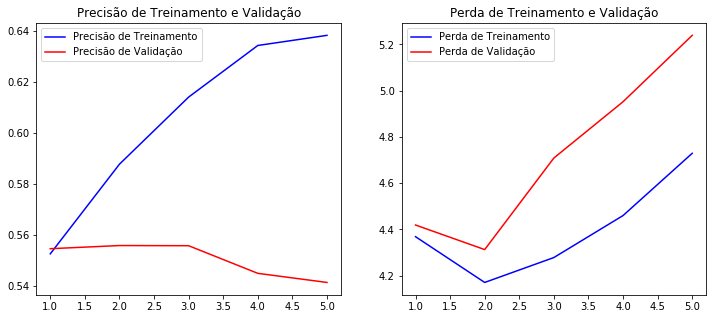

In [29]:
acc = np.array(acc).mean(axis=0)
val_acc = np.array(val_acc).mean(axis=0)
loss = np.array(loss).mean(axis=0)
val_loss = np.array(val_loss).mean(axis=0)

history.history['acc']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Precisão de Treinamento')
plt.plot(x, val_acc, 'r', label='Precisão de Validação')
plt.title('Precisão de Treinamento e Validação')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Perda de Treinamento')
plt.plot(x, val_loss, 'r', label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.legend()

plt.savefig('images/{}.png'.format('acc_loss_ann_average'))

Train on 8184 samples, validate on 2046 samples
Epoch 1/5
8184/8184 [==============================] - 22s 3ms/step - loss: 0.6992 - acc: 0.5599 - val_loss: 0.6695 - val_acc: 0.6065
Epoch 2/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.6174 - acc: 0.6912 - val_loss: 0.6618 - val_acc: 0.6002
Epoch 3/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.5304 - acc: 0.7644 - val_loss: 0.7132 - val_acc: 0.5948
Epoch 4/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.4437 - acc: 0.8149 - val_loss: 1.1036 - val_acc: 0.5890
Epoch 5/5
2558/2558 [==============================] - 1s 330us/step
Train on 8184 samples, validate on 2046 samples
Epoch 1/5
8184/8184 [==============================] - 21s 3ms/step - loss: 3.2977 - acc: 0.5484 - val_loss: 0.6868 - val_acc: 0.5562
Epoch 2/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.6859 - acc: 0.5610 - val_loss: 0.6869 - val_acc: 0.5562
Epoch 3/5
8184/8184 [==========

/home/flpncc/anaconda3/envs/datascience/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.522320). Check your callbacks.
  % delta_t_median)


8184/8184 [==============================] - 28s 3ms/step - loss: 0.7070 - acc: 0.5696 - val_loss: 0.6715 - val_acc: 0.5963
Epoch 2/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.6030 - acc: 0.6990 - val_loss: 0.7336 - val_acc: 0.6056
Epoch 3/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.4317 - acc: 0.8248 - val_loss: 0.8558 - val_acc: 0.5811
Epoch 4/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.2012 - acc: 0.9322 - val_loss: 1.8783 - val_acc: 0.5533
Epoch 5/5
2558/2558 [==============================] - 1s 328us/step
Train on 8184 samples, validate on 2046 samples
Epoch 1/5
8184/8184 [==============================] - 23s 3ms/step - loss: 5.1143 - acc: 0.5596 - val_loss: 0.6779 - val_acc: 0.5562
Epoch 2/5
8184/8184 [==============================] - 17s 2ms/step - loss: 0.7002 - acc: 0.6089 - val_loss: 0.6559 - val_acc: 0.5997
Epoch 3/5
8184/8184 [==============================] - 18s 2ms/step - loss: 0.5766 - acc:

[0.5957779517576413,
 0.5488663017982799,
 0.5922595776553449,
 0.5488663017982799,
 0.5488663017982799,
 0.6106333075043184,
 0.5488663017982799,
 0.5488663017982799,
 0.4511336982017201,
 0.4511336982017201,
 0.5488663017982799,
 0.5488663017982799,
 0.5488663017982799,
 0.5488663017982799,
 0.4511336982017201,
 0.5488663017982799,
 0.4511336982017201,
 0.5488663017982799,
 0.5488663017982799,
 0.5488663017982799,
 0.5488663017982799,
 0.4511336982017201,
 0.5488663017982799,
 0.5918686472409587,
 0.5934323689451061,
 0.5918686476137789,
 0.598123533917741,
 0.5906958560444024,
 0.4511336982017201,
 0.6094605163077622]

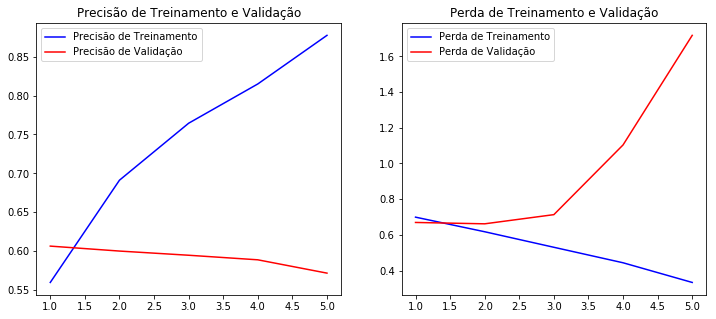

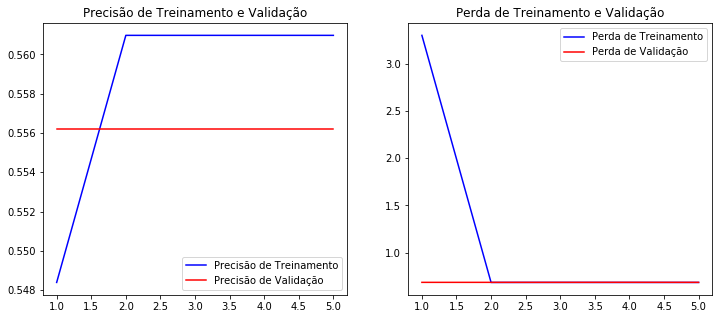

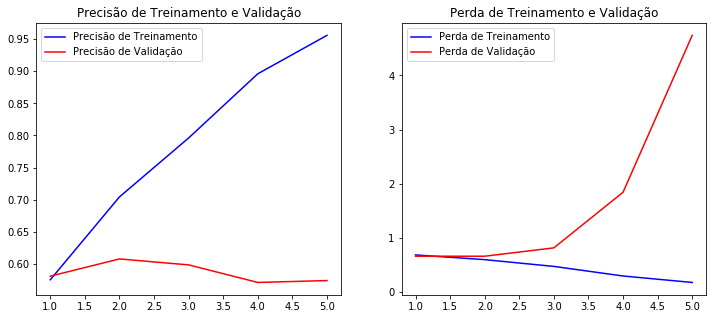

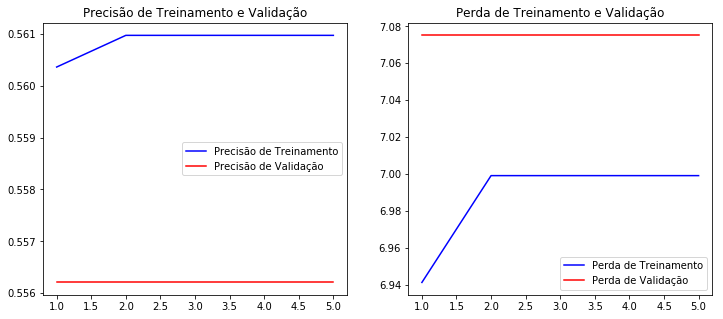

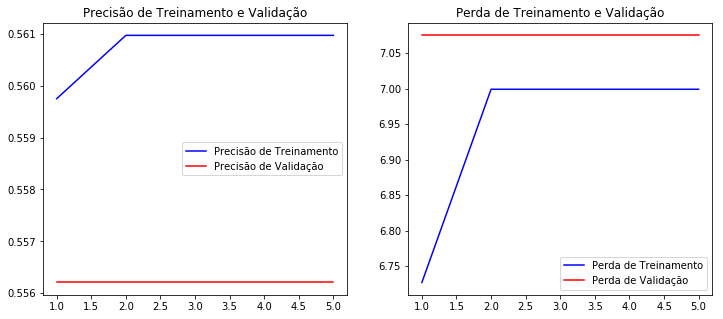

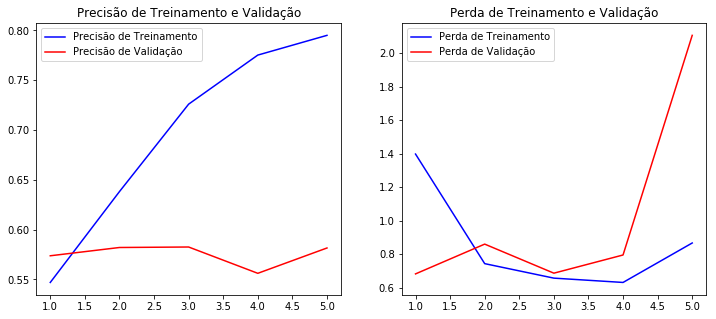

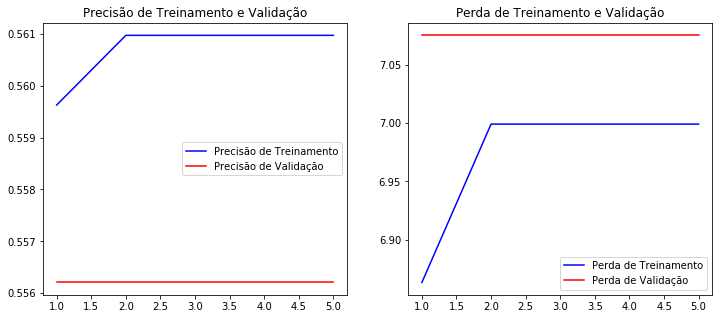

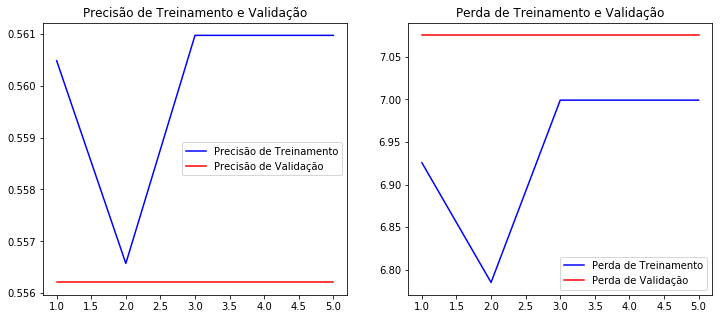

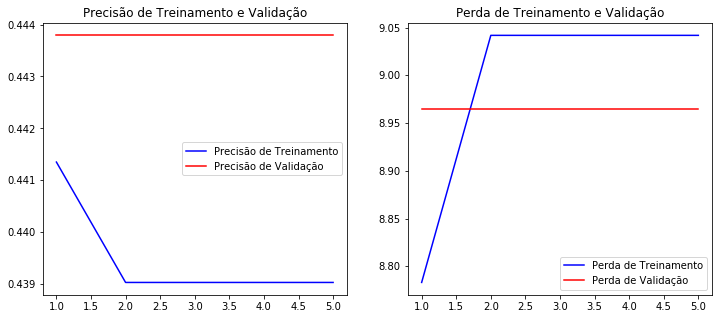

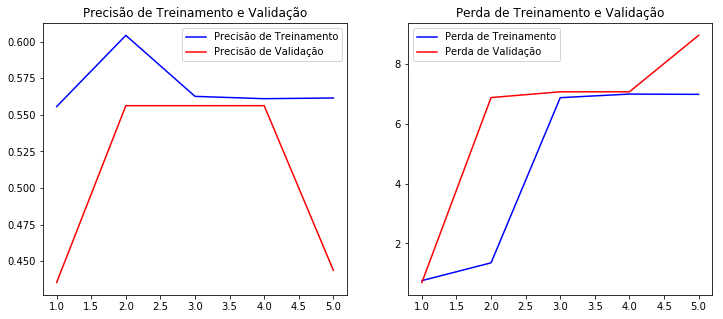

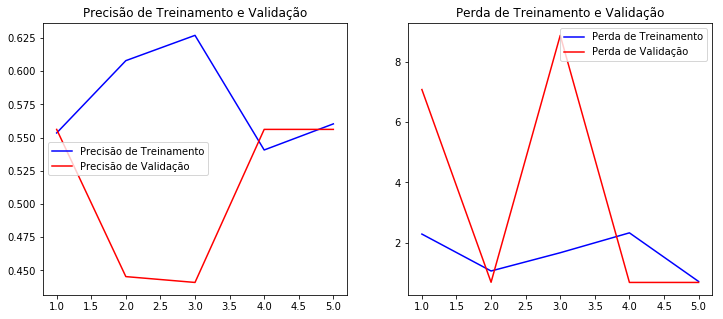

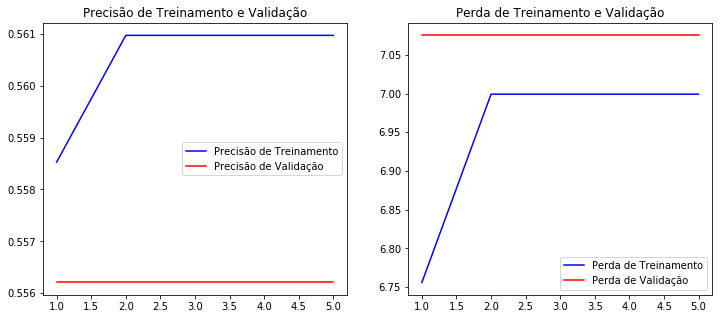

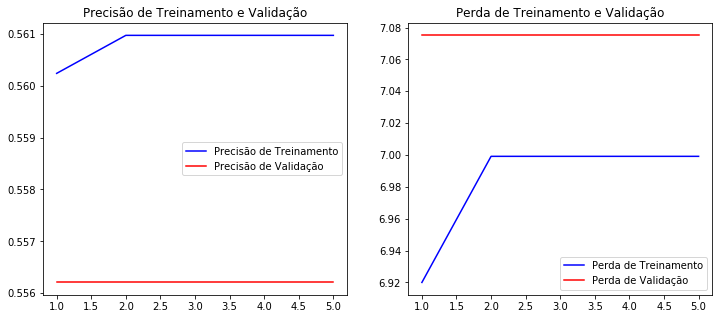

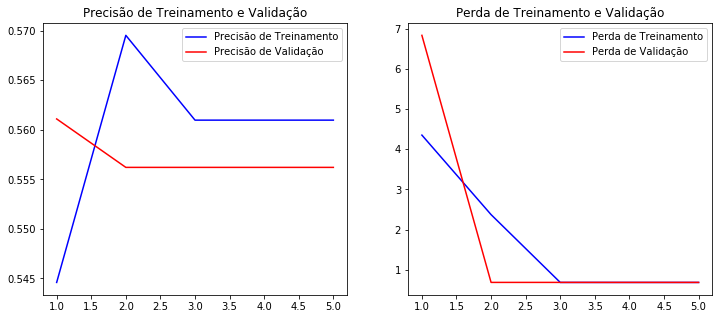

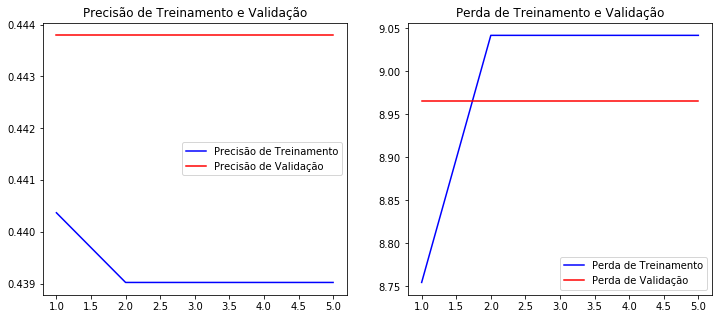

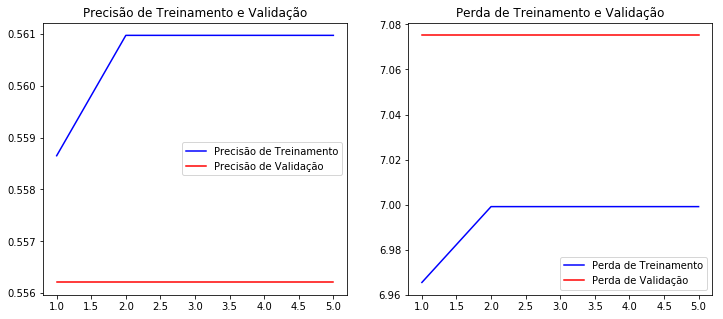

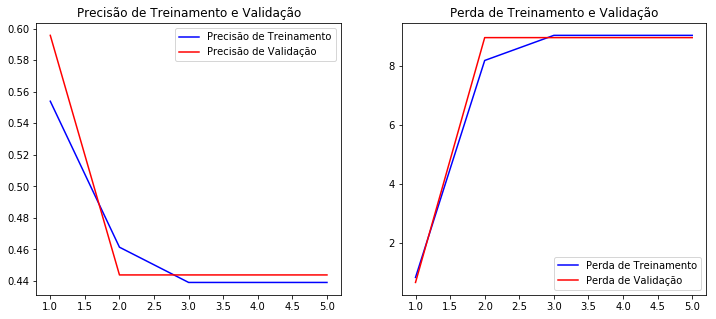

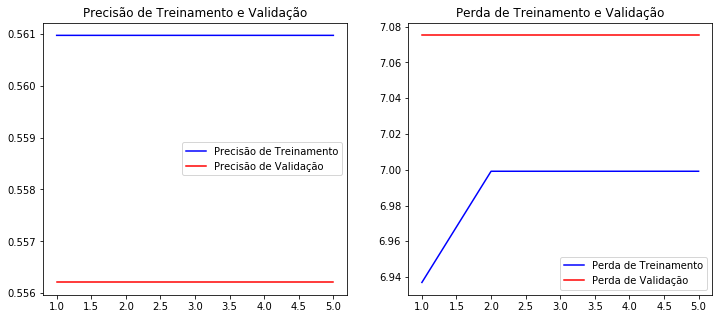

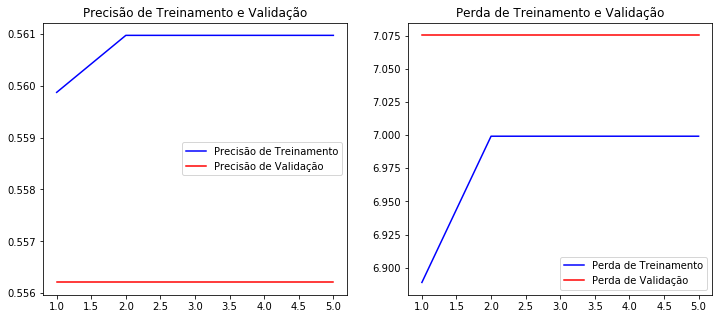

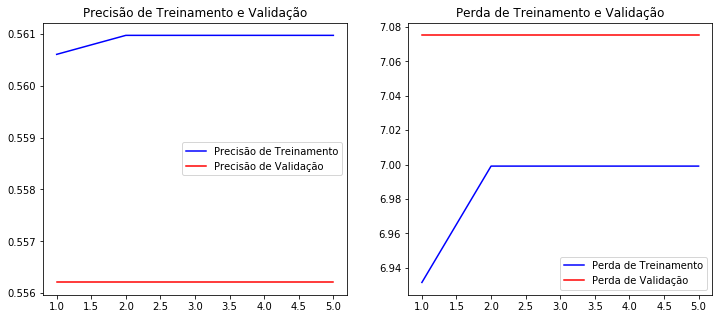

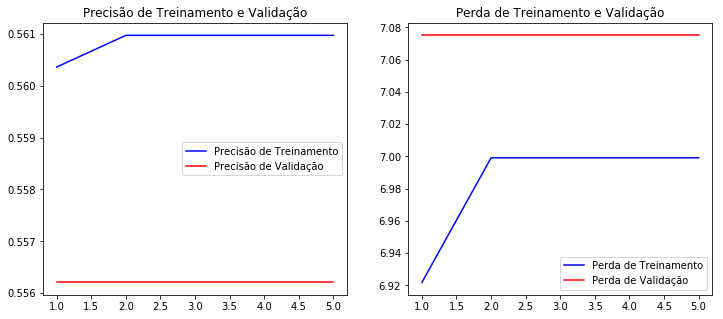

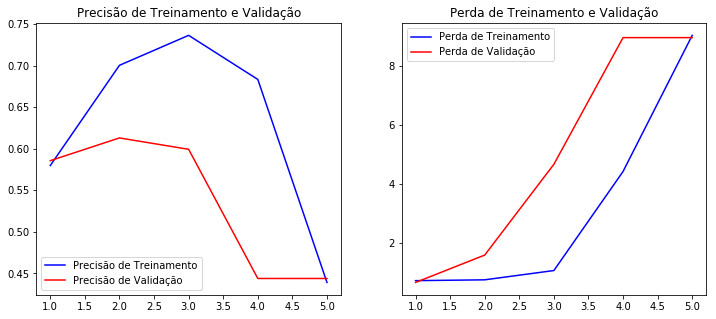

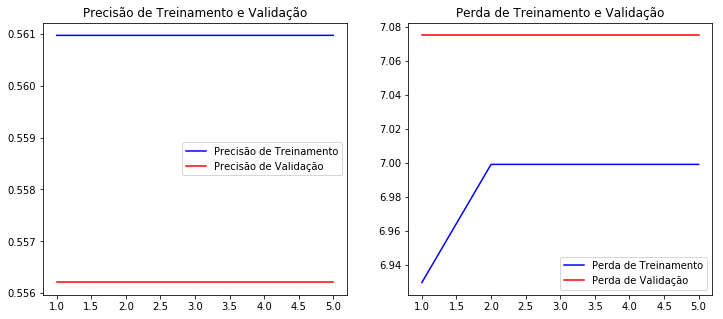

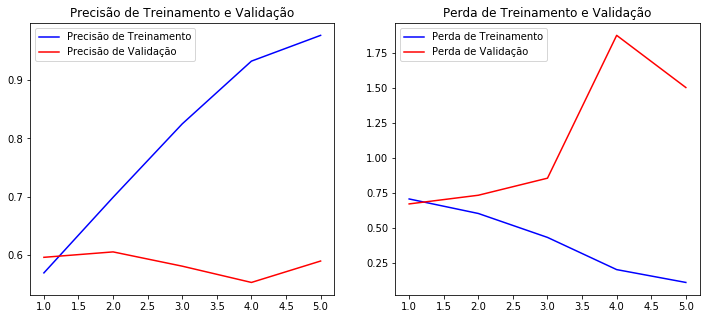

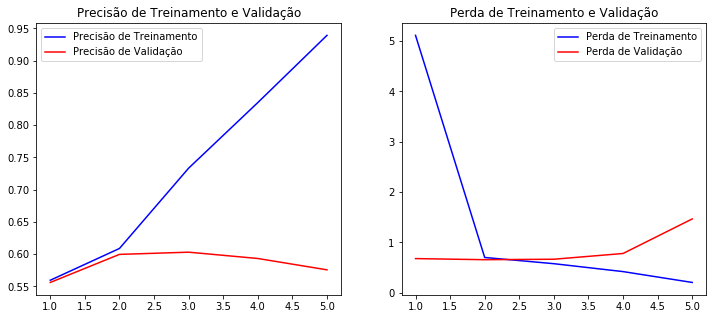

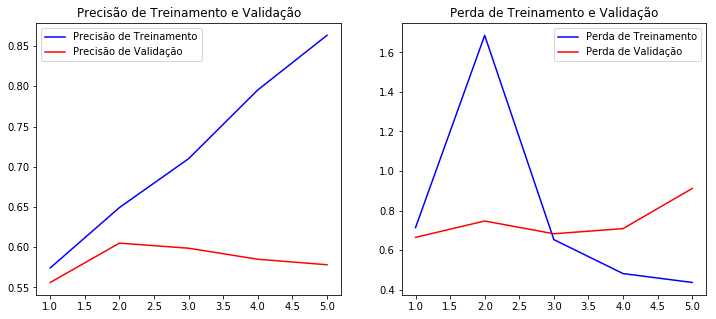

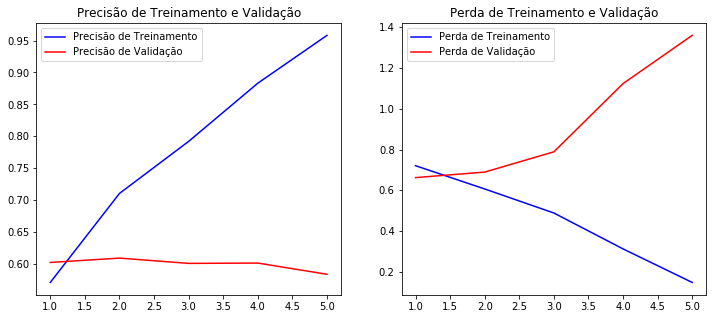

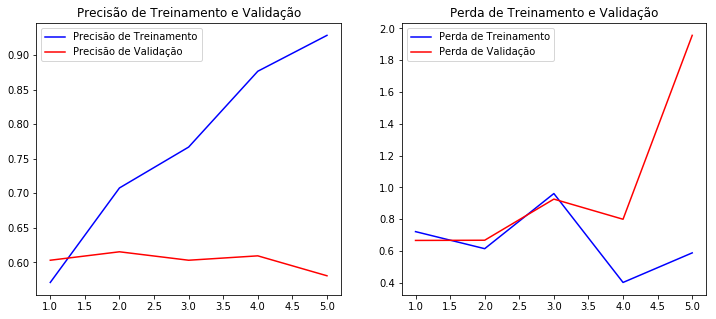

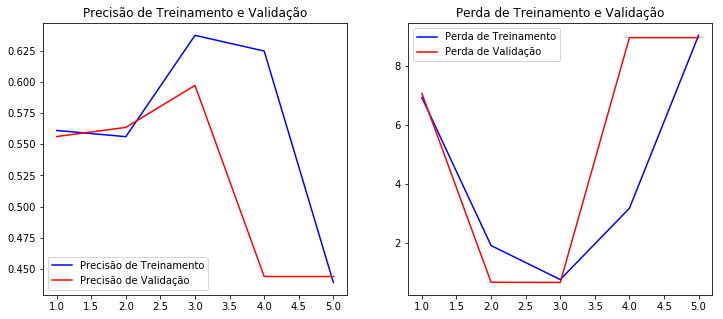

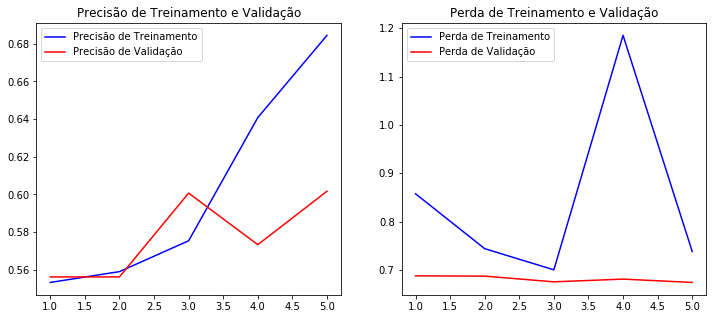

In [28]:
acc = []
val_acc = []
loss = []
val_loss = []
test_acc = []

for i in range(30):
    classifier = build_ann_classifier()
    history = classifier.fit(X_train, y_train, batch_size=50, epochs=5, validation_split=0.20)
    plot_history(history,'acc_loss_ann_{}'.format(i))

    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    test_acc.append(classifier.evaluate(X_test, y_test)[1])
#     errors = y_test - classifier.predict(X_test)
#     errors = errors.reshape(-1)

#     with open('ann_erros.txt', 'a') as file:    
#         file.write('errors <- c(')

#         for err in errors:
#             file.write('{},'.format(err))

#         file.write(')\n\n')  

test_acc

In [38]:
df = concat_datasets(pd.read_csv('datasets/train.tsv', sep='\t'),
                pd.read_csv('datasets/test.tsv', sep='\t'),
                pd.read_csv('datasets/valid.tsv', sep='\t'))

# df = df.dropna()
# df = df[df['Subject'].str.contains("economy")]

X, y = split_dataframe(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train, y_train = tokenize_dataset(tokenizer, X_train, y_train)
X_test, y_test = tokenize_dataset(tokenizer, X_test, y_test)

vocab_size = len(tokenizer.word_index) + 1

max_len = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

embedding_matrix = create_embedding_matrix('datasets/glove.6B.50d.txt', tokenizer.word_index, 50)

In [39]:
accuracy, variance = k_fold_cross_validation(X_train, y_train, build_cnn_classifier, 5, 128, 10)
accuracy

Epoch 1/10
685/685 [==============================] - 3s 5ms/step - loss: 0.6859 - acc: 0.6307
Epoch 2/10
685/685 [==============================] - 0s 540us/step - loss: 0.6700 - acc: 0.6234
Epoch 3/10
685/685 [==============================] - 0s 553us/step - loss: 0.6584 - acc: 0.6234
Epoch 4/10
685/685 [==============================] - 0s 550us/step - loss: 0.6534 - acc: 0.6234
Epoch 5/10
685/685 [==============================] - 0s 549us/step - loss: 0.6510 - acc: 0.6234
Epoch 6/10
685/685 [==============================] - 0s 533us/step - loss: 0.6493 - acc: 0.6234
Epoch 7/10
685/685 [==============================] - 0s 552us/step - loss: 0.6473 - acc: 0.6234
Epoch 8/10
685/685 [==============================] - 0s 560us/step - loss: 0.6443 - acc: 0.6234
Epoch 9/10
685/685 [==============================] - 0s 572us/step - loss: 0.6415 - acc: 0.6234
Epoch 10/10
172/172 [==============================] - 1s 7ms/step
Epoch 1/10
685/685 [==============================] - 4s 5ms/s

0.6369917058740426

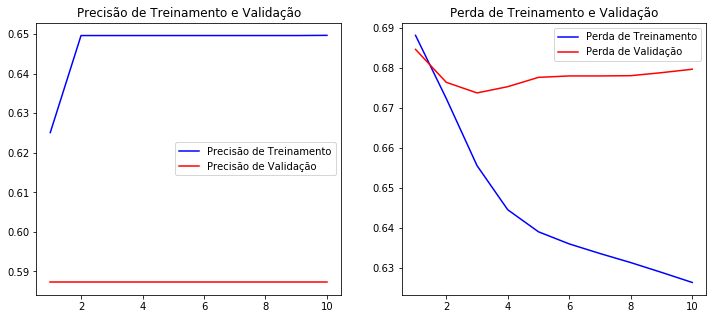

In [32]:
acc = np.array(acc).mean(axis=0)
val_acc = np.array(val_acc).mean(axis=0)
loss = np.array(loss).mean(axis=0)
val_loss = np.array(val_loss).mean(axis=0)

x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Precisão de Treinamento')
plt.plot(x, val_acc, 'r', label='Precisão de Validação')
plt.title('Precisão de Treinamento e Validação')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Perda de Treinamento')
plt.plot(x, val_loss, 'r', label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.legend()

plt.savefig('images/{}.png'.format('acc_loss_cnn_average_tuned'))

Train on 857 samples, validate on 215 samples
Epoch 1/10
857/857 [==============================] - 4s 5ms/step - loss: 0.6826 - acc: 0.6371 - val_loss: 0.6574 - val_acc: 0.6930
Epoch 2/10
857/857 [==============================] - 0s 532us/step - loss: 0.6621 - acc: 0.6371 - val_loss: 0.6310 - val_acc: 0.6930
Epoch 3/10
857/857 [==============================] - 0s 551us/step - loss: 0.6502 - acc: 0.6371 - val_loss: 0.6185 - val_acc: 0.6930
Epoch 4/10
857/857 [==============================] - 0s 552us/step - loss: 0.6456 - acc: 0.6371 - val_loss: 0.6096 - val_acc: 0.6930
Epoch 5/10
857/857 [==============================] - 1s 738us/step - loss: 0.6426 - acc: 0.6371 - val_loss: 0.6066 - val_acc: 0.6930
Epoch 6/10
857/857 [==============================] - 1s 607us/step - loss: 0.6398 - acc: 0.6371 - val_loss: 0.6098 - val_acc: 0.6930
Epoch 7/10
857/857 [==============================] - 1s 607us/step - loss: 0.6376 - acc: 0.6371 - val_loss: 0.6046 - val_acc: 0.6930
Epoch 8/10
857/857

[0.693023257200108]

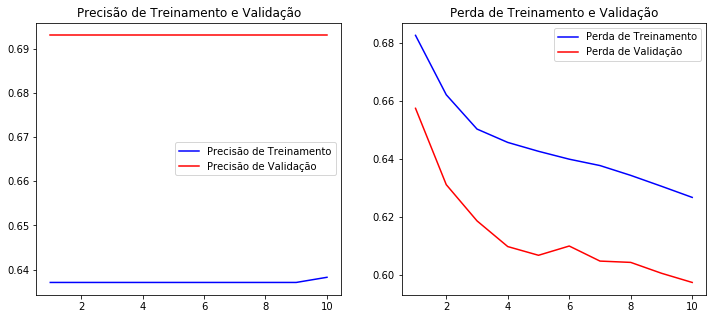

In [37]:
# accs = []

acc = []
val_acc = []
loss = []
val_loss = []
test_acc = []
for i in range(1):
    classifier = build_cnn_classifier()

    history = classifier.fit(X_train, y_train,
                        epochs=10,
                        validation_split=0.2,
                        batch_size=128)
    
    plot_history(history, 'acc_loss_cnn_{}_tuned'.format(i))
    
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    
    test_acc.append(classifier.evaluate(X_test, y_test)[1])

test_acc    

Train on 857 samples, validate on 215 samples
Epoch 1/10
857/857 [==============================] - 4s 5ms/step - loss: 0.6826 - acc: 0.6371 - val_loss: 0.6574 - val_acc: 0.6930
Epoch 2/10
857/857 [==============================] - 0s 532us/step - loss: 0.6621 - acc: 0.6371 - val_loss: 0.6310 - val_acc: 0.6930
Epoch 3/10
857/857 [==============================] - 0s 551us/step - loss: 0.6502 - acc: 0.6371 - val_loss: 0.6185 - val_acc: 0.6930
Epoch 4/10
857/857 [==============================] - 0s 552us/step - loss: 0.6456 - acc: 0.6371 - val_loss: 0.6096 - val_acc: 0.6930
Epoch 5/10
857/857 [==============================] - 1s 738us/step - loss: 0.6426 - acc: 0.6371 - val_loss: 0.6066 - val_acc: 0.6930
Epoch 6/10
857/857 [==============================] - 1s 607us/step - loss: 0.6398 - acc: 0.6371 - val_loss: 0.6098 - val_acc: 0.6930
Epoch 7/10
857/857 [==============================] - 1s 607us/step - loss: 0.6376 - acc: 0.6371 - val_loss: 0.6046 - val_acc: 0.6930
Epoch 8/10
857/857

[0.693023257200108]

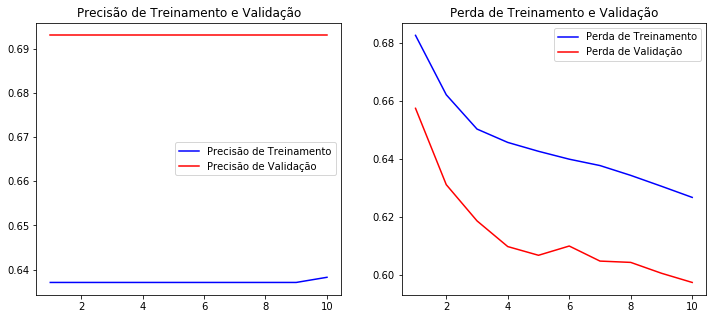

In [37]:
# accs = []

acc = []
val_acc = []
loss = []
val_loss = []
test_acc = []
for i in range(1):
    classifier = build_cnn_classifier()

    history = classifier.fit(X_train, y_train,
                        epochs=10,
                        validation_split=0.2,
                        batch_size=128)
    
    plot_history(history, 'acc_loss_cnn_{}'.format(i))
    
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    
    test_acc.append(classifier.evaluate(X_test, y_test)[1])

test_acc    

In [33]:
np.array([0.6125879592034293,
 0.6110242378721021,
 0.614542611228758,
 0.6145426112753605,
 0.605551211744477,
 0.621970289148699,
 0.6157154028913395,
 0.6047693512419222,
 0.6145426116481808,
 0.6149335416897467,
 0.6188428461598269,
 0.6129788896178155,
 0.6051602812834882,
 0.622361219889303,
 0.6020328382946161,
 0.615324472104133,
 0.6192337766208157,
 0.6164972633472917,
 0.6086786550129644,
 0.6012509775124462,
 0.6059421421588632,
 0.6114151683330908,
 0.6188428462064294,
 0.6161063329329054,
 0.6168881941344982,
 0.607505864142626,
 0.6141516812337946,
 0.6039874904131498,
 0.6149335420159645,
 0.6129788899440333]).mean()

0.6125097733100692

In [35]:
from deception_detection import concat_datasets, simplify_labels, split_dataframe, stemming_documents, encode_categorical_data, preprocess_data, k_fold_cross_validation, tokenize_dataset, create_embedding_matrix, build_ann_classifier, build_cnn_classifier